# Customer Churn Analysis Notebook

## 1. Introduction and Setup

In [1]:
# Import the modules we've created
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import our custom modules
from data_processing import DataProcessor
from train import ModelTrainer
from predict import ChurnPredictor
from database import Database

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Initialize components
data_processor = DataProcessor()
trainer = ModelTrainer()
predictor = ChurnPredictor()

## 2. Exploratory Data Analysis (EDA)

In [2]:
# Load data using our data processor
df = data_processor.load_data("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Clean the data
df_clean = data_processor.clean_data(df)

# Display basic information
print(f"Dataset shape: {df_clean.shape}")
print(f"\nChurn distribution:")
print(df_clean['Churn'].value_counts(normalize=True))

INFO:data_processing:Data loaded successfully from WA_Fn-UseC_-Telco-Customer-Churn.csv. Shape: (7043, 21)
INFO:data_processing:Converted and imputed TotalCharges. Found 0 remaining missing values (should be 0)


Dataset shape: (7043, 21)

Churn distribution:
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


### Churn rate visualization


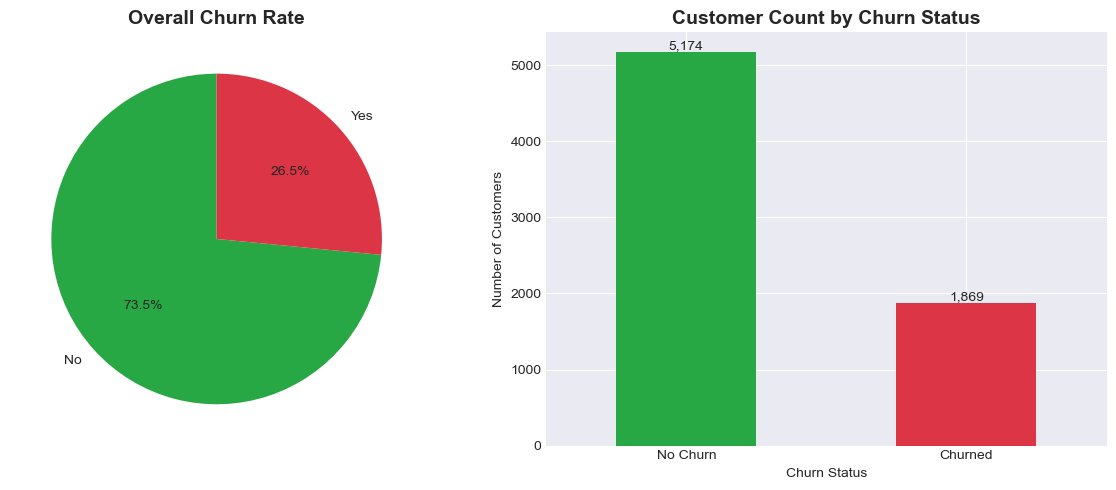

In [3]:
# Overall churn rate
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Pie chart
churn_counts = df_clean['Churn'].value_counts()
axes[0].pie(churn_counts.values, labels=churn_counts.index, autopct='%1.1f%%', 
            colors=['#28a745', '#dc3545'], startangle=90)
axes[0].set_title('Overall Churn Rate', fontsize=14, fontweight='bold')

# Bar chart with actual numbers
ax = churn_counts.plot(kind='bar', ax=axes[1], color=['#28a745', '#dc3545'])
axes[1].set_title('Customer Count by Churn Status', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Churn Status')
axes[1].set_ylabel('Number of Customers')
axes[1].set_xticklabels(['No Churn', 'Churned'], rotation=0)

# Add value labels on bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}', 
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Feature distributions


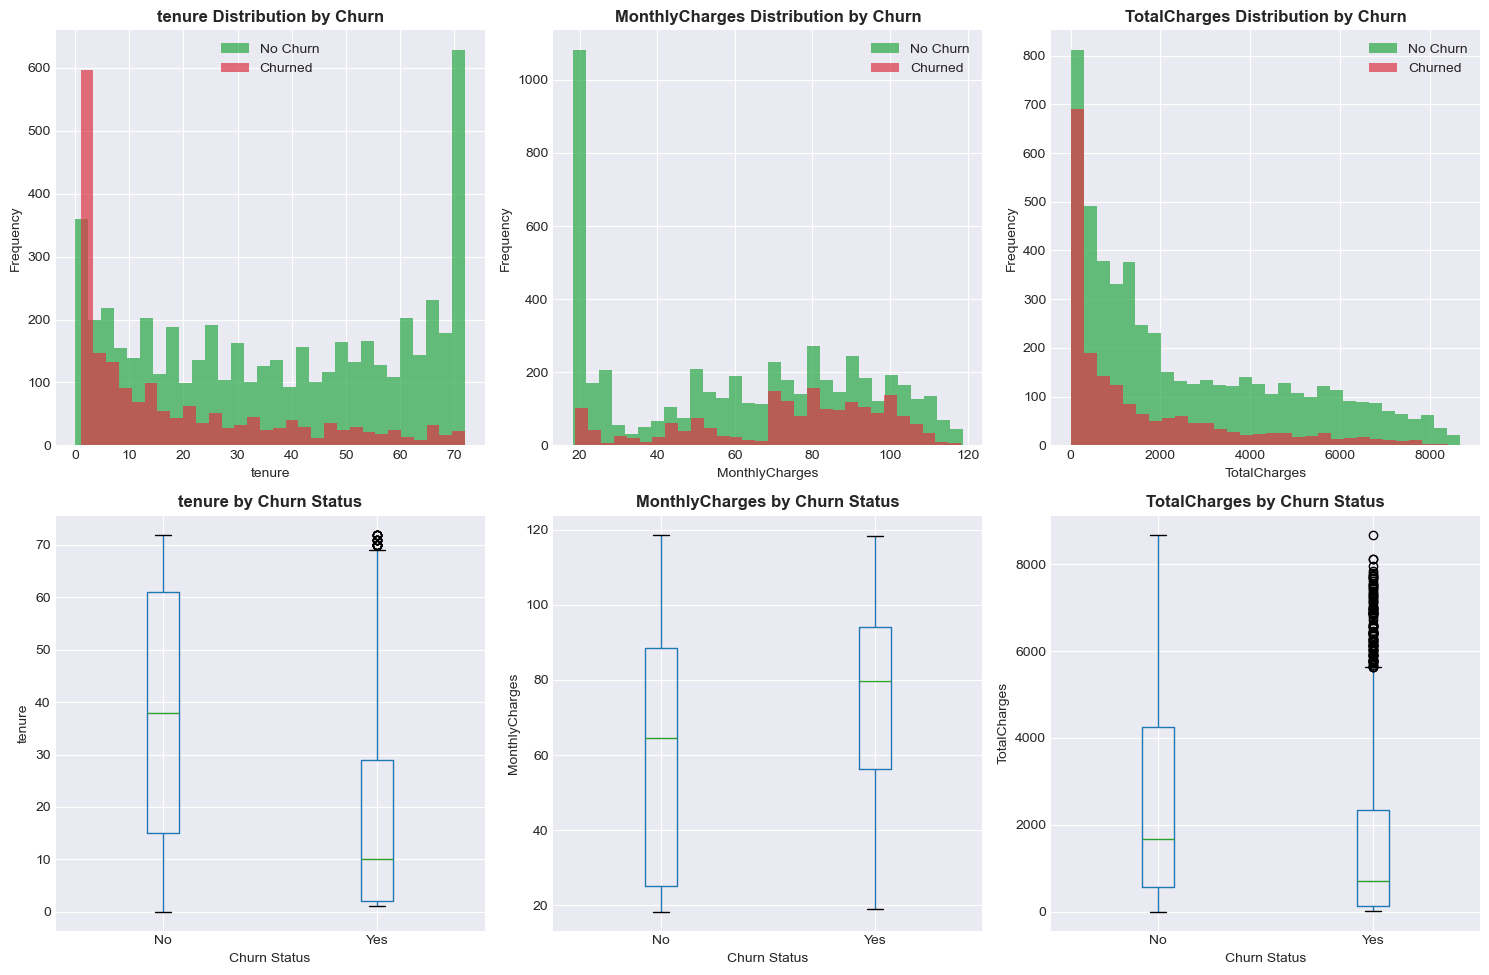

In [4]:
# Numeric feature distributions
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, feature in enumerate(numeric_features):
    # Distribution plot
    df_clean[df_clean['Churn'] == 'No'][feature].hist(bins=30, alpha=0.7, 
                                                      label='No Churn', 
                                                      ax=axes[idx], 
                                                      color='#28a745')
    df_clean[df_clean['Churn'] == 'Yes'][feature].hist(bins=30, alpha=0.7, 
                                                       label='Churned', 
                                                       ax=axes[idx], 
                                                       color='#dc3545')
    axes[idx].set_title(f'{feature} Distribution by Churn', fontweight='bold')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()
    
    # Box plot
    df_clean.boxplot(column=feature, by='Churn', ax=axes[idx+3])
    axes[idx+3].set_title(f'{feature} by Churn Status', fontweight='bold')
    axes[idx+3].set_xlabel('Churn Status')
    axes[idx+3].set_ylabel(feature)

plt.suptitle('')  # Remove default title
plt.tight_layout()
plt.show()

### Correlation analysis


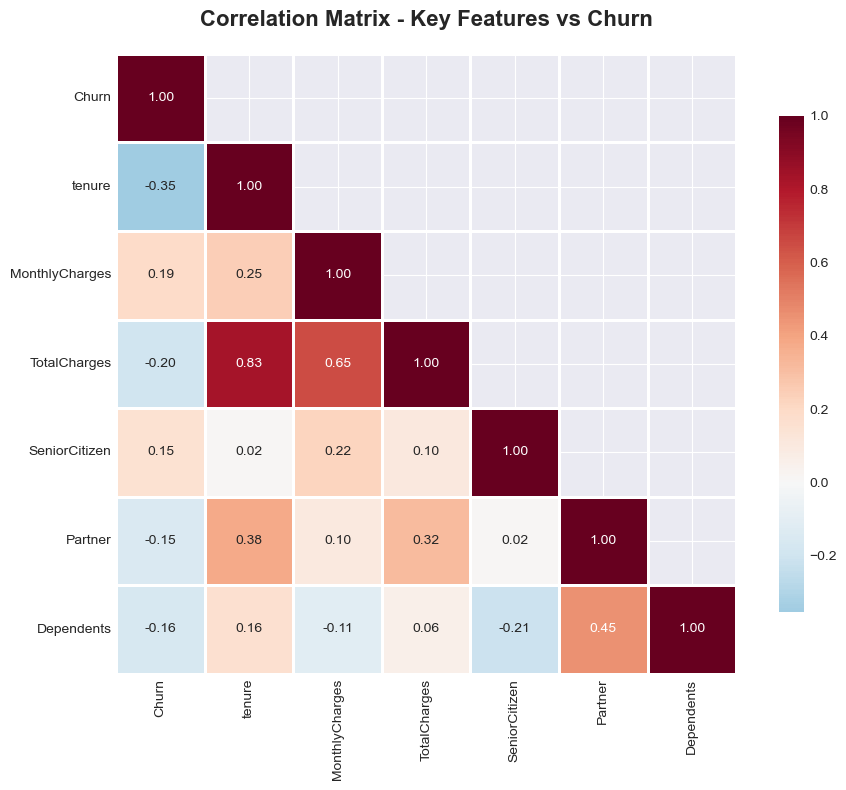

Features most correlated with Churn:
MonthlyCharges    0.193356
SeniorCitizen     0.150889
Partner          -0.150448
Dependents       -0.164221
TotalCharges     -0.198324
tenure           -0.352229
Name: Churn, dtype: float64


In [5]:

# Prepare data for correlation analysis
# Convert categorical variables to numeric
df_corr = df_clean.copy()
df_corr['Churn'] = (df_corr['Churn'] == 'Yes').astype(int)
df_corr['gender'] = (df_corr['gender'] == 'Male').astype(int)
df_corr['Partner'] = (df_corr['Partner'] == 'Yes').astype(int)
df_corr['Dependents'] = (df_corr['Dependents'] == 'Yes').astype(int)
df_corr['PhoneService'] = (df_corr['PhoneService'] == 'Yes').astype(int)
df_corr['PaperlessBilling'] = (df_corr['PaperlessBilling'] == 'Yes').astype(int)

# Select numeric columns for correlation
corr_columns = ['Churn', 'tenure', 'MonthlyCharges', 'TotalCharges', 
                'SeniorCitizen', 'Partner', 'Dependents']

# Calculate correlation matrix
correlation_matrix = df_corr[corr_columns].corr()

# Create heatmap
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix), k=1)
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            fmt='.2f', 
            cmap='RdBu_r', 
            center=0,
            square=True,
            linewidths=1,
            cbar_kws={"shrink": .8})
plt.title('Correlation Matrix - Key Features vs Churn', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Show features most correlated with churn
churn_correlations = correlation_matrix['Churn'].sort_values(ascending=False)
print("Features most correlated with Churn:")
print(churn_correlations[1:])  # Exclude self-correlation

### Contract type analysis


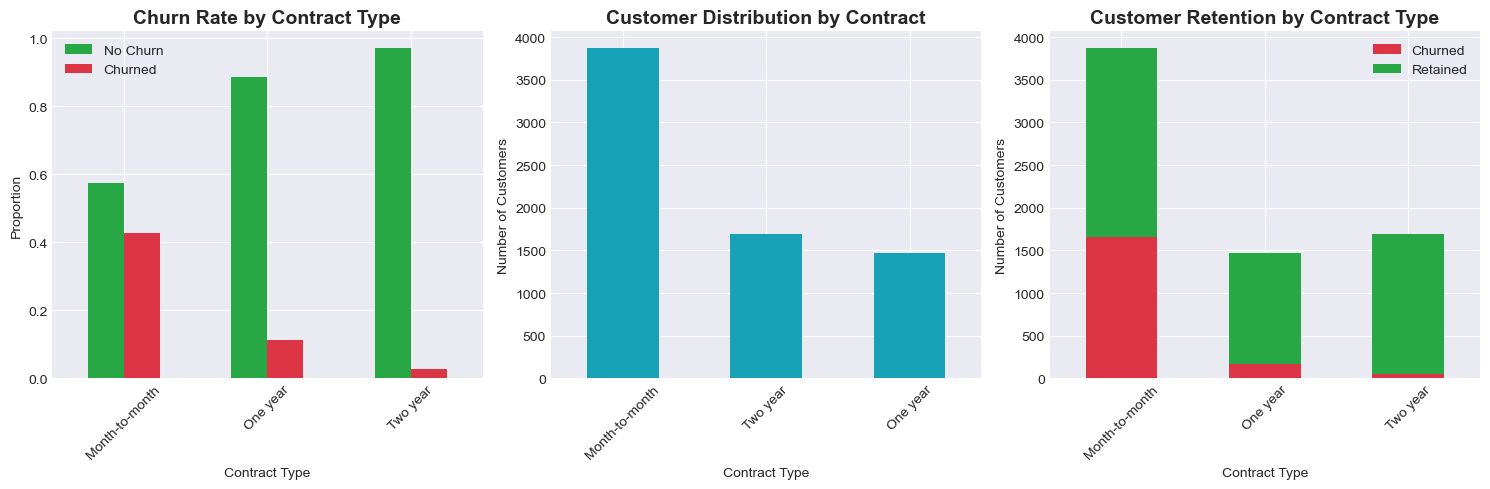

Churn Rate by Contract Type:
Month-to-month: 42.7%
One year: 11.3%
Two year: 2.8%


In [6]:
# Contract type vs Churn
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Churn rate by contract type
contract_churn = df_clean.groupby('Contract')['Churn'].value_counts(normalize=True).unstack()
contract_churn.plot(kind='bar', ax=axes[0], color=['#28a745', '#dc3545'])
axes[0].set_title('Churn Rate by Contract Type', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Contract Type')
axes[0].set_ylabel('Proportion')
axes[0].legend(['No Churn', 'Churned'])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

# Customer count by contract type
contract_counts = df_clean['Contract'].value_counts()
contract_counts.plot(kind='bar', ax=axes[1], color='#17a2b8')
axes[1].set_title('Customer Distribution by Contract', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Contract Type')
axes[1].set_ylabel('Number of Customers')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

# Churn numbers by contract type (absolute)
contract_churn_abs = df_clean[df_clean['Churn'] == 'Yes'].groupby('Contract').size()
total_customers = df_clean.groupby('Contract').size()
churn_data = pd.DataFrame({
    'Churned': contract_churn_abs,
    'Retained': total_customers - contract_churn_abs
})
churn_data.plot(kind='bar', stacked=True, ax=axes[2], color=['#dc3545', '#28a745'])
axes[2].set_title('Customer Retention by Contract Type', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Contract Type')
axes[2].set_ylabel('Number of Customers')
axes[2].legend(['Churned', 'Retained'])
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# Print statistics
print("Churn Rate by Contract Type:")
for contract in df_clean['Contract'].unique():
    churn_rate = (df_clean[df_clean['Contract'] == contract]['Churn'] == 'Yes').mean() * 100
    print(f"{contract}: {churn_rate:.1f}%")

### Tenure analysis


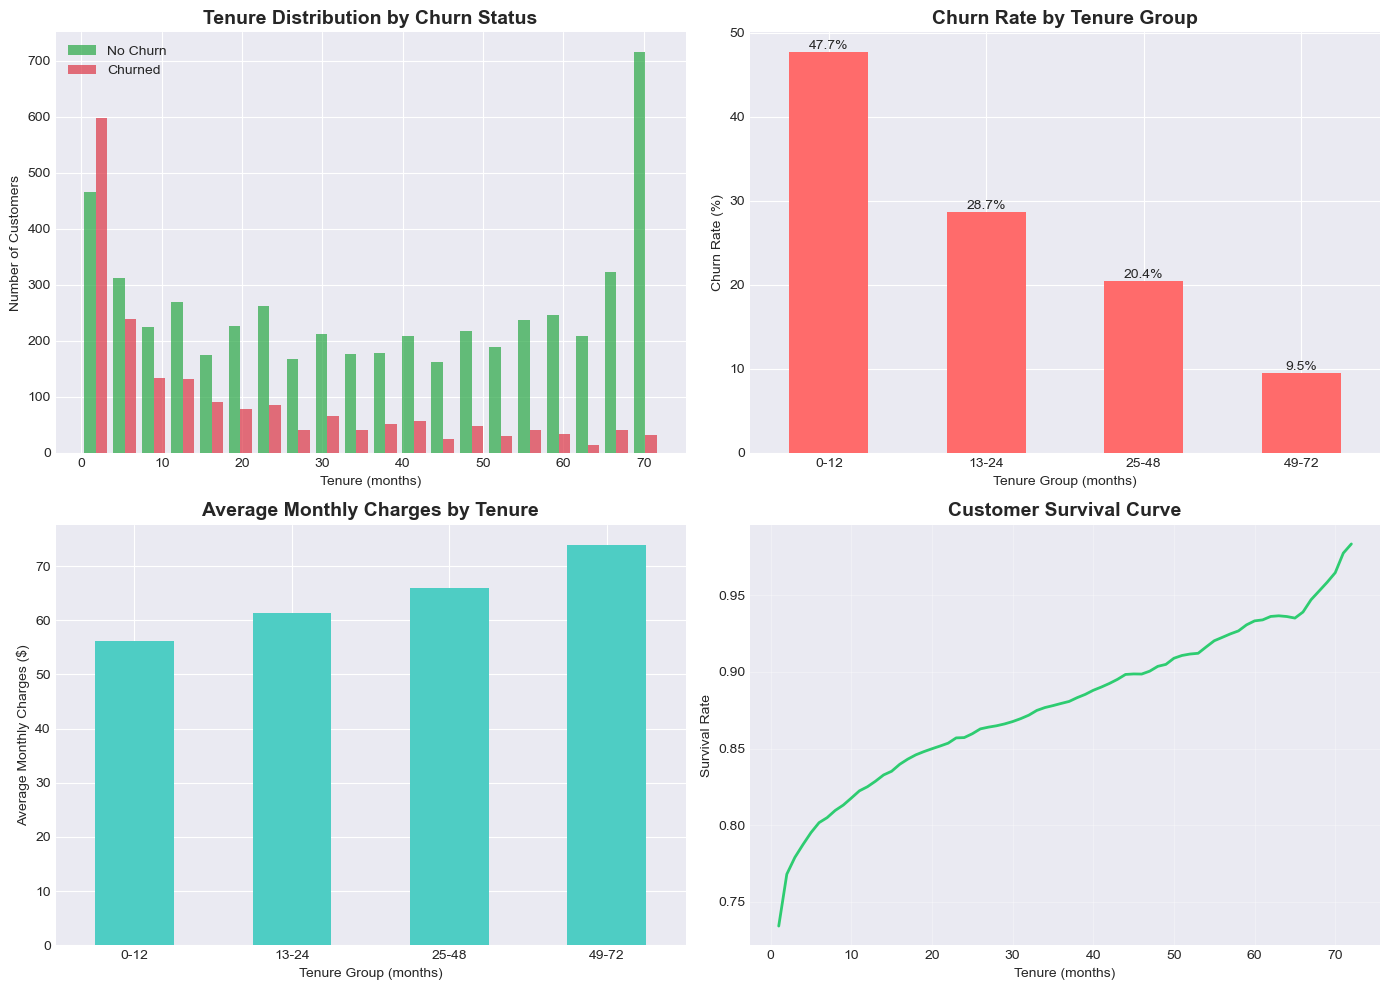

In [7]:
# Tenure analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Tenure distribution by churn
axes[0, 0].hist([df_clean[df_clean['Churn'] == 'No']['tenure'],
                 df_clean[df_clean['Churn'] == 'Yes']['tenure']], 
                bins=20, alpha=0.7, label=['No Churn', 'Churned'],
                color=['#28a745', '#dc3545'])
axes[0, 0].set_title('Tenure Distribution by Churn Status', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Tenure (months)')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].legend()

# Churn rate by tenure groups
tenure_groups = pd.cut(df_clean['tenure'], 
                      bins=[0, 12, 24, 48, 72], 
                      labels=['0-12', '13-24', '25-48', '49-72'])
churn_by_tenure = df_clean.groupby(tenure_groups, observed=False)['Churn'].apply(lambda x: (x == 'Yes').mean() * 100)

churn_by_tenure.plot(kind='bar', ax=axes[0, 1], color='#ff6b6b')
axes[0, 1].set_title('Churn Rate by Tenure Group', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Tenure Group (months)')
axes[0, 1].set_ylabel('Churn Rate (%)')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=0)

# Add value labels
for p in axes[0, 1].patches:
    axes[0, 1].annotate(f'{p.get_height():.1f}%', 
                       (p.get_x() + p.get_width()/2., p.get_height()),
                       ha='center', va='bottom')

# Average monthly charges by tenure group
avg_charges_by_tenure = df_clean.groupby(tenure_groups, observed=False)['MonthlyCharges'].mean()
avg_charges_by_tenure.plot(kind='bar', ax=axes[1, 0], color='#4ecdc4')
axes[1, 0].set_title('Average Monthly Charges by Tenure', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Tenure Group (months)')
axes[1, 0].set_ylabel('Average Monthly Charges ($)')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=0)

# Survival curve (customers retained over time)
max_tenure = df_clean['tenure'].max()
survival_data = []
for t in range(1, max_tenure + 1):
    retained = (df_clean[df_clean['tenure'] >= t]['Churn'] == 'No').sum()
    total = (df_clean['tenure'] >= t).sum()
    survival_rate = retained / total if total > 0 else 0
    survival_data.append(survival_rate)


axes[1, 1].plot(range(1, max_tenure + 1), survival_data, color='#2ecc71', linewidth=2)
axes[1, 1].set_title('Customer Survival Curve', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Tenure (months)')
axes[1, 1].set_ylabel('Survival Rate')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Service usage patterns

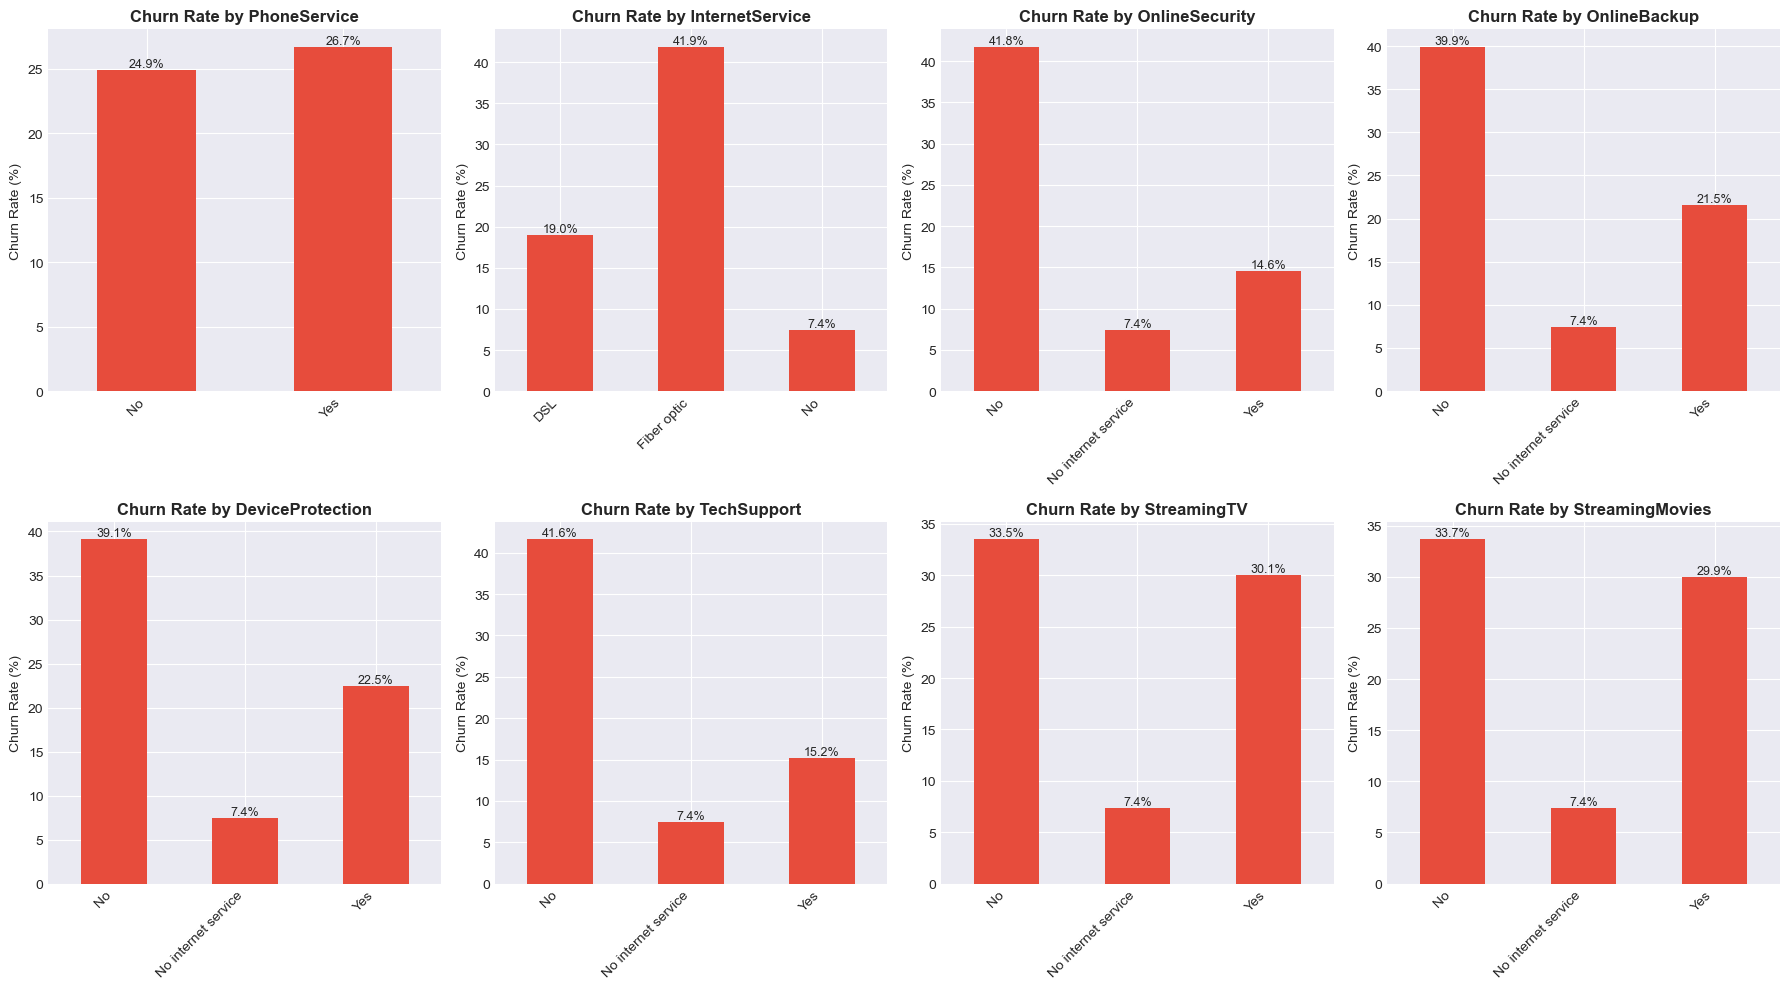

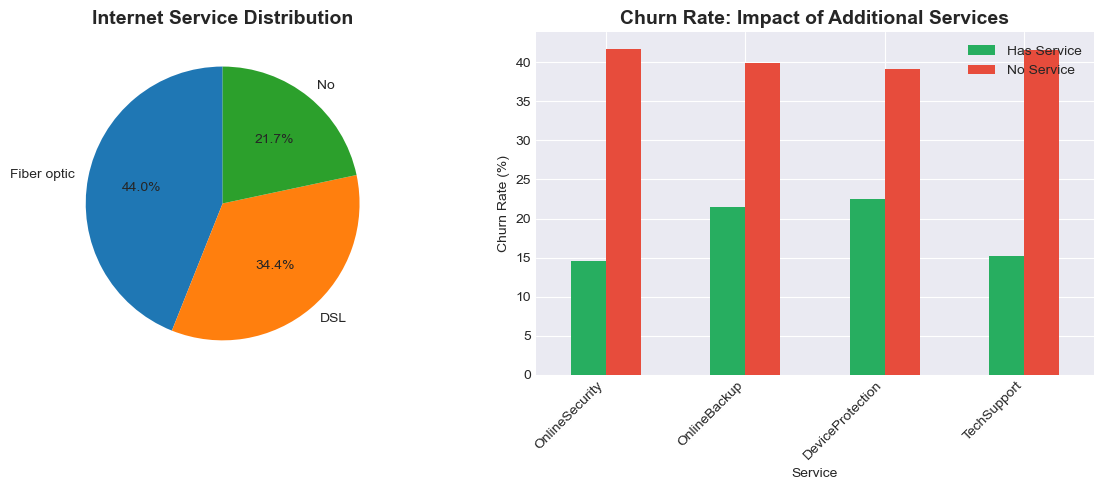

In [8]:
services = ['PhoneService', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.ravel()

for idx, service in enumerate(services):
    # Calculate churn rate for each service category
    service_churn = df_clean.groupby(service)['Churn'].apply(lambda x: (x == 'Yes').mean() * 100)
    
    # Plot
    service_churn.plot(kind='bar', ax=axes[idx], color='#e74c3c')
    axes[idx].set_title(f'Churn Rate by {service}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('Churn Rate (%)')
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right')
    
    # Add value labels
    for p in axes[idx].patches:
        axes[idx].annotate(f'{p.get_height():.1f}%', 
                          (p.get_x() + p.get_width()/2., p.get_height()),
                          ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Internet service deep dive
if 'InternetService' in df_clean.columns:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Internet service distribution
    internet_counts = df_clean['InternetService'].value_counts()
    axes[0].pie(internet_counts.values, labels=internet_counts.index, 
                autopct='%1.1f%%', startangle=90)
    axes[0].set_title('Internet Service Distribution', fontsize=14, fontweight='bold')
    
    # Churn by internet service and additional services
    internet_users = df_clean[df_clean['InternetService'] != 'No']
    additional_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']
    
    service_impact = {}
    for service in additional_services:
        has_service = internet_users[internet_users[service] == 'Yes']['Churn'].eq('Yes').mean()
        no_service = internet_users[internet_users[service] == 'No']['Churn'].eq('Yes').mean()
        service_impact[service] = {'Has Service': has_service * 100, 'No Service': no_service * 100}
    
    impact_df = pd.DataFrame(service_impact).T
    impact_df.plot(kind='bar', ax=axes[1], color=['#27ae60', '#e74c3c'])
    axes[1].set_title('Churn Rate: Impact of Additional Services', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Service')
    axes[1].set_ylabel('Churn Rate (%)')
    axes[1].legend(['Has Service', 'No Service'])
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

## 3. Feature Engineering Demonstration

In [9]:
# Add engineered features
df_engineered = data_processor.calculate_derived_features(df_clean)

# Show new features
print("New engineered features:")
print(df_engineered[['MonthlyToTotalRatio', 'NumAdditionalServices', 'HasInternetService']].head(10))
print("\nFeature statistics:")
print(df_engineered[['MonthlyToTotalRatio', 'NumAdditionalServices', 'HasInternetService']].describe())




# Statistical significance of engineered features
print("\n" + "="*50)
print("Statistical Analysis of Engineered Features")
print("="*50)

from scipy import stats

# Convert Churn to binary for analysis
df_engineered['Churn_Binary'] = (df_engineered['Churn'] == 'Yes').astype(int)


INFO:data_processing:Created MonthlyToTotalRatio feature
INFO:data_processing:Created NumAdditionalServices feature
INFO:data_processing:Created HasInternetService feature


New engineered features:
   MonthlyToTotalRatio  NumAdditionalServices  HasInternetService
0             1.000000                      1                   1
1             0.030140                      2                   1
2             0.497920                      2                   1
3             0.022980                      3                   1
4             0.466205                      0                   1
5             0.121450                      3                   1
6             0.045706                      2                   1
7             0.098543                      1                   1
8             0.034405                      4                   1
9             0.016098                      2                   1

Feature statistics:
       MonthlyToTotalRatio  NumAdditionalServices  HasInternetService
count          7043.000000            7043.000000         7043.000000
mean              0.158908               2.037910            0.783331
std               

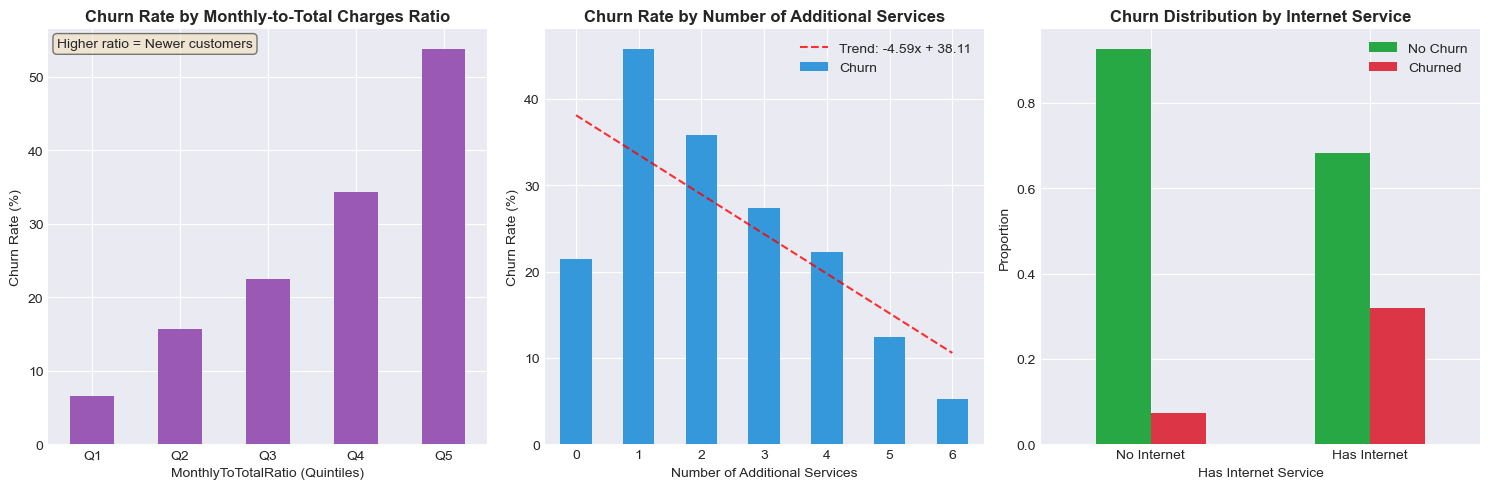

In [10]:

# Visualize the impact of engineered features
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. MonthlyToTotalRatio vs Churn
ratio_bins = pd.qcut(df_engineered['MonthlyToTotalRatio'], q=5, duplicates='drop')
churn_by_ratio = df_engineered.groupby(ratio_bins, observed=False)['Churn'].apply(lambda x: (x == 'Yes').mean() * 100)

churn_by_ratio.plot(kind='bar', ax=axes[0], color='#9b59b6')
axes[0].set_title('Churn Rate by Monthly-to-Total Charges Ratio', fontsize=12, fontweight='bold')
axes[0].set_xlabel('MonthlyToTotalRatio (Quintiles)')
axes[0].set_ylabel('Churn Rate (%)')
axes[0].set_xticklabels([f'Q{i+1}' for i in range(len(churn_by_ratio))], rotation=0)

# Add interpretation text
axes[0].text(0.02, 0.98, 'Higher ratio = Newer customers', 
             transform=axes[0].transAxes, fontsize=10, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. NumAdditionalServices vs Churn
# Calculate the churn rate by taking the mean of boolean values (True for 'Yes')
churn_rate_by_services = df_engineered.groupby('NumAdditionalServices')['Churn'].apply(lambda x: (x == 'Yes').mean() * 100)

churn_rate_by_services.plot(kind='bar', ax=axes[1], color='#3498db')
axes[1].set_title('Churn Rate by Number of Additional Services', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Number of Additional Services')
axes[1].set_ylabel('Churn Rate (%)')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

# Add trend line
# Use the index and values from the new 'churn_rate_by_services' Series
z = np.polyfit(churn_rate_by_services.index, churn_rate_by_services.values, 1)
p = np.poly1d(z)
axes[1].plot(churn_rate_by_services.index, p(churn_rate_by_services.index), "r--", alpha=0.8, label=f'Trend: {z[0]:.2f}x + {z[1]:.2f}')
axes[1].legend()
# 3. HasInternetService vs Churn
internet_churn = df_engineered.groupby('HasInternetService')['Churn'].value_counts(normalize=True).unstack()
internet_churn.plot(kind='bar', ax=axes[2], color=['#28a745', '#dc3545'])
axes[2].set_title('Churn Distribution by Internet Service', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Has Internet Service')
axes[2].set_ylabel('Proportion')
axes[2].set_xticklabels(['No Internet', 'Has Internet'], rotation=0)
axes[2].legend(['No Churn', 'Churned'])

plt.tight_layout()
plt.show()


In [11]:

# T-test for MonthlyToTotalRatio
churned_ratio = df_engineered[df_engineered['Churn_Binary'] == 1]['MonthlyToTotalRatio']
not_churned_ratio = df_engineered[df_engineered['Churn_Binary'] == 0]['MonthlyToTotalRatio']
t_stat, p_value = stats.ttest_ind(churned_ratio.dropna(), not_churned_ratio.dropna())
print(f"\nMonthlyToTotalRatio T-test:")
print(f"  Mean (Churned): {churned_ratio.mean():.4f}")
print(f"  Mean (Not Churned): {not_churned_ratio.mean():.4f}")
print(f"  T-statistic: {t_stat:.4f}, p-value: {p_value:.4e}")

# T-test for NumAdditionalServices
churned_services = df_engineered[df_engineered['Churn_Binary'] == 1]['NumAdditionalServices']
not_churned_services = df_engineered[df_engineered['Churn_Binary'] == 0]['NumAdditionalServices']
t_stat, p_value = stats.ttest_ind(churned_services, not_churned_services)
print(f"\nNumAdditionalServices T-test:")
print(f"  Mean (Churned): {churned_services.mean():.2f}")
print(f"  Mean (Not Churned): {not_churned_services.mean():.2f}")
print(f"  T-statistic: {t_stat:.4f}, p-value: {p_value:.4e}")

# Chi-square test for HasInternetService
crosstab = pd.crosstab(df_engineered['HasInternetService'], df_engineered['Churn_Binary'])
chi2, p_value, dof, expected = stats.chi2_contingency(crosstab)
print(f"\nHasInternetService Chi-square test:")
print(f"  Chi-square statistic: {chi2:.4f}, p-value: {p_value:.4e}")

# Feature correlation with target
print("\nCorrelation with Churn:")
engineered_features = ['MonthlyToTotalRatio', 'NumAdditionalServices', 'HasInternetService']
for feature in engineered_features:
    corr = df_engineered[feature].corr(df_engineered['Churn_Binary'])
    print(f"  {feature}: {corr:.4f}")


MonthlyToTotalRatio T-test:
  Mean (Churned): 0.3066
  Mean (Not Churned): 0.1055
  T-statistic: 27.6979, p-value: 2.2767e-160

NumAdditionalServices T-test:
  Mean (Churned): 1.77
  Mean (Not Churned): 2.14
  T-statistic: -7.3873, p-value: 1.6714e-13

HasInternetService Chi-square test:
  Chi-square statistic: 364.5198, p-value: 2.9203e-81

Correlation with Churn:
  MonthlyToTotalRatio: 0.3135
  NumAdditionalServices: -0.0877
  HasInternetService: 0.2279


## 4. Data Validation and Quality Checks

In [12]:
#df_engineered['TotalCharges'] = df_engineered['TotalCharges'].fillna(0)

# Validate data quality
validation_issues = data_processor.validate_data(df_engineered)

print("Data Validation Report:")
for issue_type, issues in validation_issues.items():
    if issues:
        print(f"\n{issue_type}:")
        for issue in issues:
            print(f"  - {issue}")
            


Data Validation Report:

data_type_issues:
  - HasInternetService should be categorical/object, but is int64


## 5. Model Training Process

In [13]:
X, y = data_processor.prepare_features(df_clean)

# Split data
X_train, X_test, y_train, y_test = trainer.split_data(X, y)


INFO:train:Data split - Train: (5634, 19), Test: (1409, 19)
INFO:train:Class distribution - Train: {0: 4139, 1: 1495}
INFO:train:Class distribution - Test: {0: 1035, 1: 374}


In [14]:
results = trainer.train_all_models(X_train, X_test, y_train, y_test)

# Display results
for model_name, model_results in results.items():
    print(f"\n{model_name.upper()} Results:")
    print(f"ROC AUC: {model_results['test_results']['roc_auc']:.4f}")
    print(f"Recall (Churn): {model_results['test_results']['recall_churn']:.4f}")
    print(f"F1 Score (Churn): {model_results['test_results']['f1_churn']:.4f}")

INFO:data_processing:Created preprocessing pipeline
INFO:train:
INFO:train:Training LOGISTIC Model
INFO:train:==================================================
INFO:train:Created base pipeline for logistic.
INFO:train:Starting RandomizedSearchCV for logistic (n_iter=20)...


Fitting 5 folds for each of 20 candidates, totalling 100 fits


INFO:train:Best parameters for logistic: {'resampler__k_neighbors': 7, 'resampler': SMOTE(random_state=42), 'classifier__solver': 'liblinear', 'classifier__penalty': 'l2', 'classifier__class_weight': None, 'classifier__C': 0.01}
INFO:train:Best CV score: 0.6422
INFO:train:
logistic Cross-Validation Results:
INFO:train:accuracy: 0.7614 (+/- 0.0168)
INFO:train:precision: 0.5346 (+/- 0.0217)
INFO:train:recall: 0.7953 (+/- 0.0107)
INFO:train:f1: 0.6392 (+/- 0.0185)
INFO:train:roc_auc: 0.8495 (+/- 0.0139)
INFO:train:
logistic Performance:
INFO:train:ROC AUC: 0.8474
INFO:train:Recall (Churn): 0.7995
INFO:train:F1 Score (Churn): 0.6255
INFO:train:Accuracy: 0.7459
INFO:train:Model saved to models/best_model_logistic.pkl
INFO:train:
INFO:train:Training RANDOM_FOREST Model
INFO:train:==================================================
INFO:train:Created base pipeline for random_forest.
INFO:train:Starting RandomizedSearchCV for random_forest (n_iter=20)...


Fitting 5 folds for each of 20 candidates, totalling 100 fits


INFO:train:Best parameters for random_forest: {'resampler': None, 'classifier__n_estimators': 100, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 5, 'classifier__max_features': 0.3, 'classifier__max_depth': 5, 'classifier__class_weight': 'balanced_subsample', 'classifier__bootstrap': True}
INFO:train:Best CV score: 0.6318
INFO:train:
random_forest Cross-Validation Results:
INFO:train:accuracy: 0.7524 (+/- 0.0185)
INFO:train:precision: 0.5225 (+/- 0.0224)
INFO:train:recall: 0.8020 (+/- 0.0174)
INFO:train:f1: 0.6326 (+/- 0.0202)
INFO:train:roc_auc: 0.8455 (+/- 0.0144)
INFO:train:
random_forest Performance:
INFO:train:ROC AUC: 0.8437
INFO:train:Recall (Churn): 0.7861
INFO:train:F1 Score (Churn): 0.6255
INFO:train:Accuracy: 0.7502
INFO:train:Model saved to models/best_model_random_forest.pkl
INFO:train:
INFO:train:Training GRADIENT_BOOSTING Model
INFO:train:==================================================
INFO:train:Created base pipeline for gradient_boosting.
INFO:

Fitting 5 folds for each of 20 candidates, totalling 100 fits


INFO:train:Best parameters for gradient_boosting: {'resampler__k_neighbors': 3, 'resampler': SMOTE(random_state=42), 'classifier__subsample': 1.0, 'classifier__n_estimators': 200, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.01}
INFO:train:Best CV score: 0.6323
INFO:train:
gradient_boosting Cross-Validation Results:
INFO:train:accuracy: 0.7755 (+/- 0.0121)
INFO:train:precision: 0.5604 (+/- 0.0183)
INFO:train:recall: 0.7171 (+/- 0.0165)
INFO:train:f1: 0.6290 (+/- 0.0165)
INFO:train:roc_auc: 0.8444 (+/- 0.0117)
INFO:train:
gradient_boosting Performance:
INFO:train:ROC AUC: 0.8390
INFO:train:Recall (Churn): 0.7326
INFO:train:F1 Score (Churn): 0.6277
INFO:train:Accuracy: 0.7693
INFO:train:Model saved to models/best_model_gradient_boosting.pkl
INFO:train:
INFO:train:Training XGBOOST Model
INFO:train:==================================================
INFO:train:Created base pipeline for xgboost.
INFO:train:C

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/tom/anaconda3/envs/xgb_clean/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:05:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1745056743506/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/tom/anaconda3/envs/xgb_clean/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:05:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1745056743506/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/tom/anaconda3/envs/xgb_clean/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:05:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1745056743506/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/tom/anaconda3/envs/xgb_clean/lib/python3.11/site-packages/xgboost/traini


LOGISTIC Results:
ROC AUC: 0.8474
Recall (Churn): 0.7995
F1 Score (Churn): 0.6255

RANDOM_FOREST Results:
ROC AUC: 0.8437
Recall (Churn): 0.7861
F1 Score (Churn): 0.6255

GRADIENT_BOOSTING Results:
ROC AUC: 0.8390
Recall (Churn): 0.7326
F1 Score (Churn): 0.6277

XGBOOST Results:
ROC AUC: 0.8448
Recall (Churn): 0.6738
F1 Score (Churn): 0.6109


## 6. Model Performance Visualization

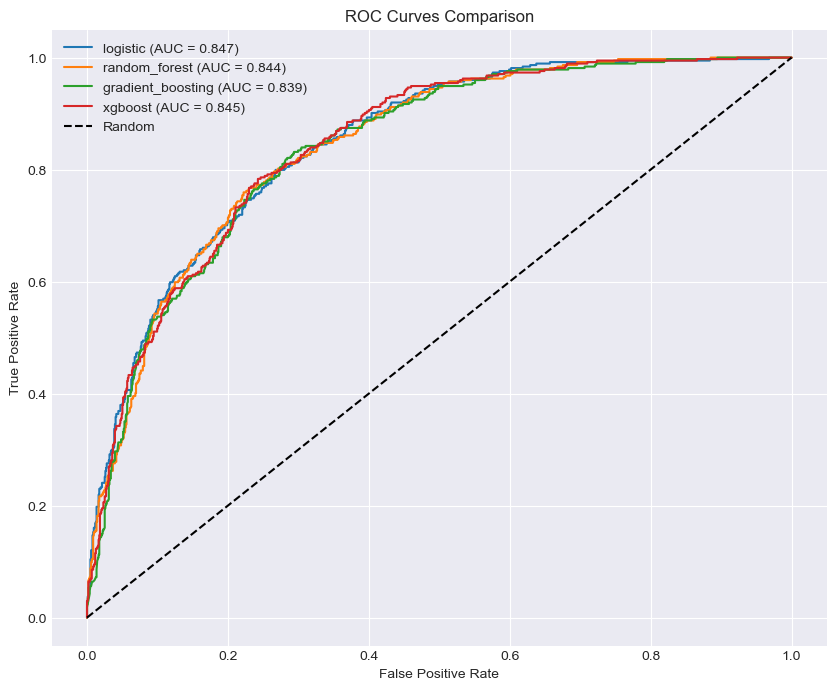

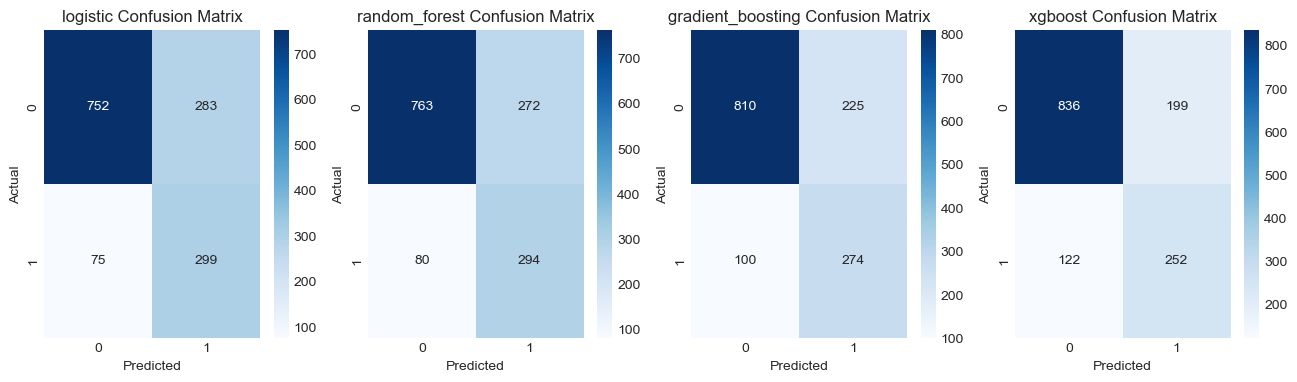

In [15]:
# ROC Curves comparison
plt.figure(figsize=(10, 8))
for model_name, model_results in results.items():
    roc_data = model_results['test_results']['roc_curve']
    plt.plot(roc_data['fpr'], roc_data['tpr'], 
             label=f'{model_name} (AUC = {model_results["test_results"]["roc_auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.show()

# Confusion matrices
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for idx, (model_name, model_results) in enumerate(results.items()):
    cm = model_results['test_results']['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'{model_name} Confusion Matrix')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

## 7. Feature Importance Analysis

In [16]:
# Get the best model pipeline
best_model_name = trainer.best_model
best_pipeline = results[best_model_name]['pipeline']

# Extract feature names after preprocessing
preprocessor = best_pipeline.named_steps.get('preprocessor')
feature_names = preprocessor.get_feature_names_out()


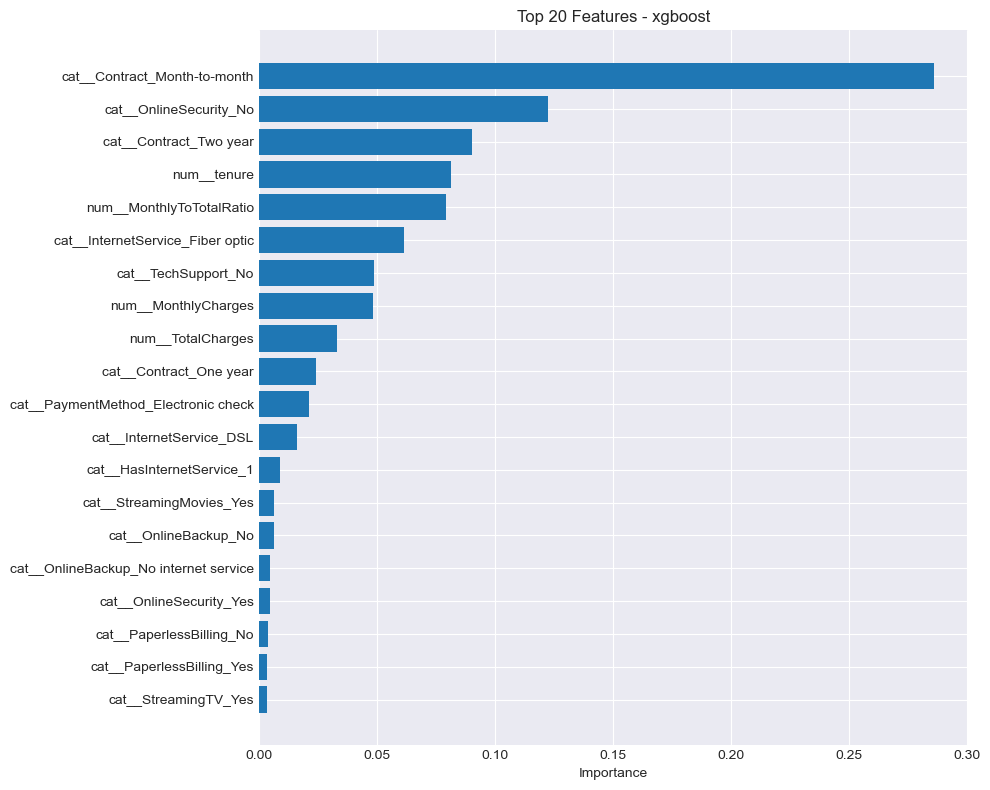

In [17]:
random_forest_pipeline = results['random_forest']['pipeline']
# Extract feature names after preprocessing
random_forest_preprocessor = random_forest_pipeline.named_steps.get('preprocessor')
random_forest_feature_names = random_forest_preprocessor.get_feature_names_out()


random_forest_importance_df = trainer.get_feature_importance(random_forest_pipeline, random_forest_feature_names)
    
    # Visualize top features
top_features = random_forest_importance_df.head(20)
plt.figure(figsize=(10, 8))
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Importance')
plt.title(f'Top 20 Features - {model_name}')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 8. Making Predictions (DEMO)

In [18]:
# Load the predictor
predictor.load_model()

# Example: High-risk customer profile
high_risk_customer = {
    "customerID": "DEMO-001",
    "gender": "Male",
    "SeniorCitizen": 0,
    "Partner": "No",
    "Dependents": "No",
    "tenure": 2,
    "PhoneService": "Yes",
    "MultipleLines": "No",
    "InternetService": "Fiber optic",
    "OnlineSecurity": "No",
    "OnlineBackup": "No",
    "DeviceProtection": "No",
    "TechSupport": "No",
    "StreamingTV": "No",
    "StreamingMovies": "No",
    "Contract": "Month-to-month",
    "PaperlessBilling": "Yes",
    "PaymentMethod": "Electronic check",
    "MonthlyCharges": 85.0,
    "TotalCharges": 170.0
}

# Get prediction with explanation
result = predictor.predict_single(high_risk_customer)
explanation = predictor.explain_prediction(high_risk_customer)

print("Prediction Results:")
print(f"Churn Prediction: {result['churn_prediction']}")
print(f"Churn Probability: {result['churn_probability']:.3f}")
print(f"Risk Level: {result['risk_level']}")

print("\nImportant Factors:")
for factor in explanation['important_factors']:
    print(f"  - {factor}")

print("\nRetention Recommendations:")
for rec in explanation['recommendations']:
    print(f"  - {rec}")

INFO:predict:Model loaded successfully from models/best_model_gradient_boosting.pkl
INFO:data_processing:Converted and imputed TotalCharges. Found 0 remaining missing values (should be 0)
INFO:predict:Prediction for customer DEMO-001: Yes (probability: 0.815)
INFO:data_processing:Converted and imputed TotalCharges. Found 0 remaining missing values (should be 0)
INFO:predict:Prediction for customer DEMO-001: Yes (probability: 0.815)
INFO:data_processing:Converted and imputed TotalCharges. Found 0 remaining missing values (should be 0)


Prediction Results:
Churn Prediction: Yes
Churn Probability: 0.815
Risk Level: Very High

Important Factors:
  - Month-to-month contract (higher churn risk)
  - New customer (tenure: 2 months)
  - Electronic check payment (associated with higher churn)
  - No online security service
  - No tech support service
  - High monthly charges ($85.00)

Retention Recommendations:
  - Offer incentive to switch to annual contract
  - Implement new customer retention program
  - Bundle additional services with discount
  - Review pricing and offer competitive rate
  - Priority intervention - personal outreach recommended


## 9. Business Insights and Recommendations

In [19]:
# Customer Segmentation based on risk
# Use the model to score all customers
all_predictions = predictor.predict_batch(df_clean.to_dict('records'))

# Create risk segments
risk_df = pd.DataFrame(all_predictions)
risk_segments = risk_df['risk_level'].value_counts()

# Visualize risk distribution
plt.figure(figsize=(10, 6))
risk_segments.plot(kind='bar')
plt.title('Customer Distribution by Risk Level')
plt.xlabel('Risk Level')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()


INFO:data_processing:Converted and imputed TotalCharges. Found 0 remaining missing values (should be 0)
INFO:data_processing:Created MonthlyToTotalRatio feature
INFO:data_processing:Created NumAdditionalServices feature
INFO:data_processing:Created HasInternetService feature


KeyboardInterrupt: 

In [ ]:

# ===============================================================
# Calculate potential revenue impact - COMPLETED CODE STARTS HERE
# ===============================================================

# 1. Merge predictions with original data to get monthly charges
# Ensure the customer ID column name matches for merging.
# In predict.py it's 'customer_id' and in the original data it's 'customerID'.
predictions_df = pd.DataFrame(all_predictions).rename(columns={'customer_id': 'customerID'})
impact_df = pd.merge(df_clean, predictions_df, on='customerID')

# 2. Calculate "Revenue at Risk" for each customer
# This is the expected monthly revenue loss for each customer.
impact_df['RevenueAtRisk'] = impact_df['MonthlyCharges'] * impact_df['churn_probability']

# 3. Aggregate the impact by risk segment
risk_impact = impact_df.groupby('risk_level').agg(
    NumberOfCustomers=('customerID', 'count'),
    TotalMonthlyRevenue=('MonthlyCharges', 'sum'),
    TotalRevenueAtRisk=('RevenueAtRisk', 'sum')
).round(2)

# 4. Define a logical order for the risk levels for better visualization
risk_order = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
risk_impact = risk_impact.reindex(risk_order)

# 5. Display the results in a table
print("="*40)
print("Potential Monthly Revenue Impact by Risk Segment")
print("="*40)
print(risk_impact)
print("\n'TotalRevenueAtRisk' is the sum of (MonthlyCharges * ChurnProbability) for all customers in the segment.\n")


# 6. Visualize the revenue impact with a stacked bar chart
fig, ax = plt.subplots(figsize=(12, 7))

# Plot total monthly revenue for each segment
risk_impact['TotalMonthlyRevenue'].plot(kind='bar', ax=ax, color='skyblue', label='Total Monthly Revenue')

# On the same axes, plot the revenue at risk
risk_impact['TotalRevenueAtRisk'].plot(kind='bar', ax=ax, color='salmon', label='Revenue at Risk')

# Formatting the plot
ax.set_title('Total Monthly Revenue vs. Revenue at Risk by Segment', fontsize=16)
ax.set_xlabel('Customer Risk Level', fontsize=12)
ax.set_ylabel('Monthly Revenue ($)', fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels to the bars for clarity
for p in ax.patches:
    ax.annotate(f"${int(p.get_height()):,}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points')

plt.tight_layout()
plt.show()